---
# 0. 라이브러리 
---

In [1]:
# 문장을 토큰화하는 모듈 설치
!pip3 install torchtext==0.10.0
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
2023-02-14 12:19:38.254331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 12:19:39.117284: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-14 12:19:39.117401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import spacy
import numpy as np
import torch.nn.functional as F

import random
import math
from tqdm.notebook import tqdm

from torchsummary import summary as summary_
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 1. Data
----

In [4]:
# 문장을 토큰화하는 모델 로드
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [5]:
# tokenizer function 생성
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

#### Field 정의

- sequential : 시퀀스 데이터 여부. (True가 기본값)
- use_vocab : 단어 집합을 만들 것인지 여부. (True가 기본값)
- tokenize : 어떤 토큰화 함수를 사용할 것인지 지정. (string.split이 기본값)
- lower : 영어 데이터를 전부 소문자화한다. (False가 기본값)
- batch_first : 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부. (False가 기본값)
- is_target : 레이블 데이터 여부. (False가 기본값)
- fix_length : 최대 허용 길이. 이 길이에 맞춰서 패딩 작업(Padding)이 진행된다.

In [6]:
# torchtext의 Field는 데이터를 어떻게 처리할지 조절합니다.
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

---
### 1-1. Data Load
----

In [7]:
# 30,000개의 영어, 독일, 프랑스어 문장을 포함합니다.
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC,TRG))

In [8]:
print('Train 개수:', len(train_data))
print('Test 개수:', len(test_data))
print('Valid 개수:', len(valid_data))

Train 개수: 29000
Test 개수: 1000
Valid 개수: 1014


In [9]:
print(vars(train_data.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


---
### 1-2. Vocab 생성
----

- min_freq = 해당 인수를 사용하여 n회 이상 나타내는 토큰만 어휘에 표시   
   n-1회 나타날 경우 <UNK\>으로 표시

In [10]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [11]:
print('Train Vocab의 수:', len(SRC.vocab))
print('Test Vocab의 수:', len(TRG.vocab))

Train Vocab의 수: 7853
Test Vocab의 수: 5893


In [12]:
batch_size = 128

# Iterator를 통해 원본 문장과 배치 문장과 동일하게 패딩 처리
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=batch_size, device=device)

---
# 2. Model
----

#### Convolution Seq2Seq

- 만약 input 문장이 6개의 Token을 가지고 있다면 각 Token에 2개씩 총 12개의 context 벡터를 얻게 됨

- 2개의 context 벡터는 conved 벡터와 combined 벡터이다 

- conved 벡터는 input 시퀀스에 각각의 컨볼루션 레이어를 통과해 얻어지는 값이다.  
  각 레이어의 출력을 feature 맵 또는 activation이라고 하며, 다음 단계에서 결합되어 combined 벡터를 얻게된다.

- combined 벡터는 각 개별 컨볼루션 레이어에 의해 추출된 정보를 결합하는 모든 벡터의 연결 또는 합계를 뜻한다.  
  combined 벡터는 전체 입력 시퀀스에 대한 정보를 포함하고 Decoder가 대상 시퀀스를 생성하는데 도움이 되는 context 벡터로 Decoder에 공급된다. 

---
### 2-1. Encoder
----

<img src='https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/convseq2seq1.png'>

1. Token은 embedding 계층을 통과  

  해당 계층에서는 반복적인 연결이 없기 때문에 시퀀스 내 Token의 순서에 대해서 알지 못한다.

2. 순서를 알기 위해서 두 번째 embedding 레이어인 Positional embedding 레이어를지난다.  
  
   Token 자체의 순서가 아니라 시퀀스 내 토큰의 위치인 표준 embedding 레이어이다.  

  <sos\> 토큰은 0번째 순서가 된다.

3. Token과 positional embedding은 Token에 대한 정보와 시퀀스 내 위치를 포함하는 벡터를 얻기 위해 합쳐(elementwise sum) 지게 된며 이를 embbedding vector라고 한다.

4. 합쳐진 embedding vector를 필요한 hidden dimension 크기를 가지는 선형 벡터로 변환하는 Linear 레이어를 통과하게 된다. 

5. 이후 convolution 레이어를 지나게 된다. 이 부분은 블랙박스라고 볼 수 있다. 

6. conv 블록을 통과한 벡터는 또 다른 선형 레이어를 통해 embedding dimension 크기를 가지는 벡터로 변환된다. 

7. 마지막으로 각 Token에 대한 combined 벡터를 얻기 위해 residual connection을 통해 embedding 벡터로 합산된다. 

---
##### 2-1-1. Convolution Block
----

<img src='https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/convseq2seq2.png'>

1. 입력 문장에 대해서 패딩 처리를 한다.   
  
  Why?_ 컨볼루션 레이어를 통과하게 된다면 문장의 길이가 줄어들게 되기 때문에 들어가는 문장과 나오는 문장을 동일한 길이로 맞춰주기 위해서 사용한다.

  만약 패딩이 없다면 나오는 문장의 길이는 들어가는 문장의 길이보다 filter_size -1 만큼 작을 것

2. 여기서 output_hid_dim의 차원은 input_hid_dim 2배가 되도록 설계를 한다. 

  Why_ GLU activation 때문  [$GLU(x) = x_1 * sigmoid(x_2)$]

  - GLU 는 LSTM, GRU와 비슷한 Gate 매커니즘을 활성화 기능 내에 포함하고 있음

  - 전달되는 정보의 양을 결정하는 "Gate"부분과 전달되는 실제 정보를 포함하는 "Actual output" 2부분으로 나눠진다. 

  - "Gate" 부분은 Sigmoid를 통해 0~1 시이의 값을 생성하고, "Actual output" 부분의 가중치를 측정하는데 사용된다. 

  - 가중치 측정을 통해 입력이 중요할 때에는 "Gate"를 오픈하고, 반대의 경우 닫는다. 

  - 결론적으로 입력이 2개의 부분으로 분할 되기 때문에 output_hid_dim의 차원은 2배 커야 한다.  
    즉, input_hid_dim의 차원의 크기가 2배로 증가되는 셈이다.

3. 컨볼루션 레이어를 통과하기 전의 벡터와 결합(Residual)을 통해 GLU 활성화 함수를 통과한 후의 Token의 hid_dim_size는 컨볼루션 블록에 들어갔을 때와 동일하다. 

4. 마지막 블록을 통과해 메인 Encoder로 돌아가며, 선형 계층을통해 공급되어 conved 출력을 얻은 다음 combined 출력을 얻기 위해 토큰의 element wise sum을 통해 합산하게 된다. 

---
##### nn.ModuleList와 nn.Sequential의 차이점
----

- 모듈을 리스트로 저장하여 더 간편하게 사용하기 위함 (모듈을 반복할 때 사용하기 용이)

- 우선, nn.ModuleList는 nn.Sequential과 마찬가지로 nn.Module의 list를 input으로 받는다.

- 이는 Python list와 마찬가지로, nn.Module을 저장하는 역할을 한다. index로 접근도 할 수 있다.

- 하지만 nn.Sequential과 다르게 forward() method가 없다.

- 또한, 안에 담긴 module 간의 connection도 없다.



In [13]:
class Encoder(nn.Module):
  def __init__(self, 
               input_dim, 
               emb_dim, 
               hid_dim, 
               n_layers, 
               kernel_size, 
               dropout,
               device,
               max_len = 100):
    super().__init__()

    assert kernel_size % 2 == 1, "Kernel size must be odd"

    self.device = device
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
    # 토큰 임베딩
    self.tok_embedding = nn.Embedding(input_dim, emb_dim)

    # 시퀀스 내 토큰의 순서를 알기 위한 Positional embedding
    self.pos_embedding = nn.Embedding(max_len, emb_dim)

    self.emb2hid = nn.Linear(emb_dim, hid_dim)

    self.hid2emb = nn.Linear(hid_dim, emb_dim)

    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim,
                                         out_channels = 2 * hid_dim, # GLU 활성화 함수 때문에 아웃풋의 값을 2배 크게 만들어 줘야 함
                                         kernel_size = kernel_size,
                                         padding = (kernel_size -1) // 2)
                                for _ in range(n_layers)]) # n_layer의 수 만큼 ModuleList의 요소를 iterable하게 접근해서 반복

    self.dropout = nn.Dropout(dropout)                               

  def forward(self, src):  # src = [batch_size, src_len]

    batch_size = src.shape[0] 
    src_len = src.shape[1]   

    # Positional embedding을 위한 pos tensor값 생성     # pos = [0, 1, 2, 3, ..., src_len - 1]
    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)    # pos = [batch_size, src_len]

    # 토큰 임베딩과 포지션 임베딩 
    tok_embedded = self.tok_embedding(src)          # [batch_size, src_len, emb_dim]
    pos_embedded = self.pos_embedding(pos)          # [batch_size, src_len, emb_dim]

    
    # element wise sum을 통한 토큰과 포지션 임베딩 결합
    embedded = self.dropout(tok_embedded + pos_embedded) # embedded = [batch_size, src_len, emb_dim]
    
    # emb_dim -> hid_dim으로 변경하기 위한 선형 레이어 통과
    conv_input = self.emb2hid(embedded)             # conv_input = [batch_size, src_len, hid_dim]

    # permute를 통한 차원 재배치
    conv_input = conv_input.permute(0,2,1)          # conv_input = [batch_size, hid_dim , src_len]

    # convolution block에 통과 
    for i, conv in enumerate(self.convs):

      # conv layer 통과 
      conved = conv(self.dropout(conv_input))       # conved = [batch_size, 2 * hid_dim, src_len]

      # GLU 활성화 함수 통과 
      conved = F.glu(conved, dim = 1)               # conved = [batch_size, hid_dim, src_len]

      # Residual connection
      conved = (conved + conv_input) * self.scale   # conved = [batch_size, hid_dim, src_len]

      # 다음 iterate를 위해 conv_input을 conved로 설정
      conv_input = conved

    # 차원 재배치를 통해 hid_dim -> emb_dim으로 변환
    conved = self.hid2emb(conved.permute(0,2,1))    # conved = [batch_size, src_len, emb_dim]

    # element wise sum을 통한 Residual connection
    combined = (conved + embedded) * self.scale     # combined  = [batch_Size, src_len, emb_dim]

    return conved, combined

---
### 2-2. Decoder
----

<img src='https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/convseq2seq3.png'>

1. Encoder와 다르게 Residual connection이 마지막 레이어여 연결하지 않는다  
  대신 컨볼루션 블록에 공급되어 사용된다. 

2. Encoder에서 Decoder로 정보를 공급하기 위해서 Encoder에서 나온 conved 값과 combined값을 다시 컨볼루션 블록 내에서 사용된다. 

3. Decoder의 출력은 emb_dim -> out_dim까지 선형 계층을 이루고 있다.  
  이는 다음 단어가 무엇이 되어야 하는지 예측하는데 사용 된다. 

---
##### 2-2-1. Convolution Block
----

<img src='https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/convseq2seq4.png'>

1. 문장 전체에 동일하게 패딩을 하는 것이 아닌, 문장의 시작 부분에만 패딩을 처리한다.   
  
  Why_ 모든 대상을 순차적으로 처리하지 않고 동시에 병렬로 처리하기 때문에  
  단어 앞에 토큰만 볼 수 있도록 처리해야 한다. 

  모델이 출력해야 하는 토큰을 보게 된다면 모델은 단순히 다음 단어를 직접 출력하게 된다.

  이는 번역하는 방법을 배우는 것이 아닌, 단순히 복사하는 방법을 배우는 셈이 되어 성능이 좋지 않다

2. GLU 활성화 함수를 지난 후 Residual block을 인코딩된 표현과 현재 단어의 임베딩을 사용하여 Attention을 계산하게 된다. 

  1. Attention은 먼저 Linear 레이어를 통과해 hid_dim을 emb_dim의 차원과 동일한 크기로 변경

  2. Residual connection을 통해 임베딩이 합산

  3. 인코딩된 conved와 얼마나 일치하는지를 찾아 Attention 계산을 적용하고, 인코딩된 combined에 대한 weighted sum을 얻음으로써 적용한다. 

- 인코딩된 conved으로 Attention을 계산한다음 인코딩된 combined에 대한 weighted sum을 계산하는가? 

  - 인코딩된 conved이 인코딩된 시퀏느에 대해 더 큰 context를 얻는데 좋은 반면, 

    인코딩된 combined은 특정 토큰에 대한 더 많은 정보를 가지고 있으므로 예측하는데 더 유용하다고 주장하기 떄문이다. 

In [14]:
class Decoder(nn.Module):
  def __init__(self,
               output_dim,
               emb_dim,
               hid_dim,
               n_layers,
               kernel_size,
               dropout, 
               trg_pad_idx,
               device,
               max_len = 100):
    super().__init__()

    self.kernel_size = kernel_size
    self.trg_pad_idx = trg_pad_idx
    self.device = device

    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

    self.tok_embedding = nn.Embedding(output_dim, emb_dim)
    self.pos_embedding = nn.Embedding(max_len, emb_dim)

    self.emb2hid = nn.Linear(emb_dim, hid_dim)
    self.hid2emb = nn.Linear(hid_dim, emb_dim)

    self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
    self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)

    self.fc_out = nn.Linear(emb_dim, output_dim)

    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                          out_channels = 2 * hid_dim, 
                                          kernel_size = kernel_size)
                                for _ in range(n_layers)])
    
    self.dropout = nn.Dropout(dropout)

  def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):

    # embedded = [batch_size, trg_len, emb_dim]
    # conved = [batch_size, hid_dim, trg_len]
    # encoder_conved, encoder_combined = [batch_size, src_len, emb_dim]

    # 차원 재배치 및 emb_dim으로 변환
    conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))             # conved_emb = [batch_size, trg_len, emb_dim]

    combined = (conved_emb + embedded) * self.scale                     # combined = [batch_size, trg_len, emb_dim]

    energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))    # energy = [batch_szie, trg_len, src_len]

    attention = F.softmax(energy, dim=2)                                # attention = [batch_size, trg_len, src_len]

    # emb_dim -> hid_dim
    attended_encoding = torch.matmul(attention, encoder_combined)       # attended_encoding = [batch size, trg len, emd dim]

    # emb dim -> hid dim
    attended_encoding = self.attn_emb2hid(attended_encoding)            # attended_encoding = [batch size, trg len, hid dim]

    # Residual connection 결합
    attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale # attended_combined = [batch_szie, hid_dim, trg_len]

    return attention, attended_combined

  def forward(self, trg, encoder_conved, encoder_combined):

    # trg = [batch_size, trg_len]
    # encoder_conved, encoder_combined = [batch_size, src_len, emb_dim]

    batch_size = trg.shape[0]
    trg_len = trg.shape[1]
        
    # position tensor 생성
    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) # pos = [batch size, trg len]
    
    # embed tokens and positions
    tok_embedded = self.tok_embedding(trg)                              # tok_embedded = [batch size, trg len, emb dim]
    pos_embedded = self.pos_embedding(pos)                              # pos_embedded = [batch size, trg len, emb dim]
    
    # element sum을 활용한 임베딩 결합
    embedded = self.dropout(tok_embedded + pos_embedded)                # embedded = [batch size, trg len, emb dim]

    # emb dim -> hid dim 변환
    conv_input = self.emb2hid(embedded)                                 # conv_input = [batch size, trg len, hid dim]
 
    # convolutional layer 재배치
    conv_input = conv_input.permute(0, 2, 1)                            # conv_input = [batch size, hid dim, trg len]
     
    batch_size = conv_input.shape[0]
    hid_dim = conv_input.shape[1]
    
    for i, conv in enumerate(self.convs):
    
        # apply dropout
        conv_input = self.dropout(conv_input)
    
        #need to pad so decoder can't "cheat"
        padding = torch.zeros(batch_size, 
                              hid_dim, 
                              self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            
        padded_conv_input = torch.cat((padding, conv_input), dim = 2)   # padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]

        # convolutional layer 통과
        conved = conv(padded_conv_input)                                # conved = [batch size, 2 * hid dim, trg len]
        
        # GLU activation function
        conved = F.glu(conved, dim = 1)                                 # conved = [batch size, hid dim, trg len]
        
        # attention 계산
        attention, conved = self.calculate_attention(embedded,          # attention = [batch size, trg len, src len]
                                                      conved, 
                                                      encoder_conved, 
                                                      encoder_combined)
        
        # residual connection
        conved = (conved + conv_input) * self.scale                     # conved = [batch size, hid dim, trg len]
        
        # set conv_input to conved for next loop iteration
        conv_input = conved
        
    conved = self.hid2emb(conved.permute(0, 2, 1))                      # conved = [batch size, trg len, emb dim]

    output = self.fc_out(self.dropout(conved))                          # output = [batch size, trg len, output dim]
      
    return output, attention
    

---
### 2-3. Seq2Seq
---

<img src='https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/convseq2seq0.png'>


In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
          
        #encoder_conved = 마지막 encoder conv block의 output
        #encoder_combined = encoder_conved + src embedding
        
        # positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src) # encoder_conved, encoder_combined = [batch size, src len, emb dim]
                    
        # predictions of next words
        # output = trg 문장에 대한 각 단어의 배치별 예측값
        # attention =  src 문장에 대한 배치별 attention scores
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

---
# 3. Model setting
----

In [16]:
# 하이퍼 파라미터 지정
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
emb_dim = 256 # 임베딩 차원
hid_dim = 512 # 각 conv 블록은 hid_dim * 2의 크기

enc_layers = 10 # Encoder의 conv ㅊ블록의 수
dec_layers = 10 # Decoder의 conv ㅊ블록의 수

enc_kernel_size = 3
dec_kernel_size = 3

enc_dropout = 0.25
dec_dropout = 0.25

trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]

In [17]:
# 모델 생성
enc = Encoder(input_dim, emb_dim, hid_dim, enc_layers, enc_kernel_size, enc_dropout, device)
dec = Decoder(output_dim, emb_dim, hid_dim, dec_layers, dec_kernel_size, dec_dropout, trg_pad_idx, device)

model = Seq2Seq(enc, dec).to(device)

In [18]:
model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [19]:
# 모델의 학습가능한 파라미터 수 측정
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainableparameters')

The model has 37,351,173 trainableparameters


In [20]:
# optimizer
optimizer = optim.Adam(model.parameters())

# loss function
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx)

---
# 4. Train
---

In [21]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator)):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        # output = [batch size, trg len - 1, output dim]
        # trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        # output = [batch size * trg len - 1, output dim]
        # trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(tqdm(iterator)):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            # output = [batch size, trg len - 1, output dim]
            # trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            # output = [batch size * trg len - 1, output dim]
            # trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [23]:
num_epochs = 10
clip = 0.1

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
      
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 4.404 | Train PPL:  81.813
	 Val. Loss: 3.402 |  Val. PPL:  30.011


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 3.308 | Train PPL:  27.343
	 Val. Loss: 2.525 |  Val. PPL:  12.488


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 2.747 | Train PPL:  15.603
	 Val. Loss: 2.204 |  Val. PPL:   9.059


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 2.473 | Train PPL:  11.863
	 Val. Loss: 2.055 |  Val. PPL:   7.810


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 2.301 | Train PPL:   9.981
	 Val. Loss: 1.946 |  Val. PPL:   6.999


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 2.180 | Train PPL:   8.850
	 Val. Loss: 1.890 |  Val. PPL:   6.620


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 2.084 | Train PPL:   8.039
	 Val. Loss: 1.836 |  Val. PPL:   6.274


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 2.015 | Train PPL:   7.500
	 Val. Loss: 1.800 |  Val. PPL:   6.047


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 1.957 | Train PPL:   7.077
	 Val. Loss: 1.783 |  Val. PPL:   5.948


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

	Train Loss: 1.907 | Train PPL:   6.735
	 Val. Loss: 1.770 |  Val. PPL:   5.873


In [24]:
# best val loss일 때의 가중치를 불러옵니다.
model.load_state_dict(torch.load('tut1-model.pt'))

# test loss를 측정합니다.
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

  0%|          | 0/8 [00:00<?, ?it/s]

| Test Loss: 1.818 | Test PPL:   6.159 |


---
# 5. Inference
----

In [25]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [31]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'holz', 'aus', 'spielhaus', 'ein', 'in', 'klettert', 'mädchen', 'kleines', 'ein']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [32]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'is', 'climbing', 'into', 'a', 'playhouse', 'of', 'wood', '.', '<eos>']


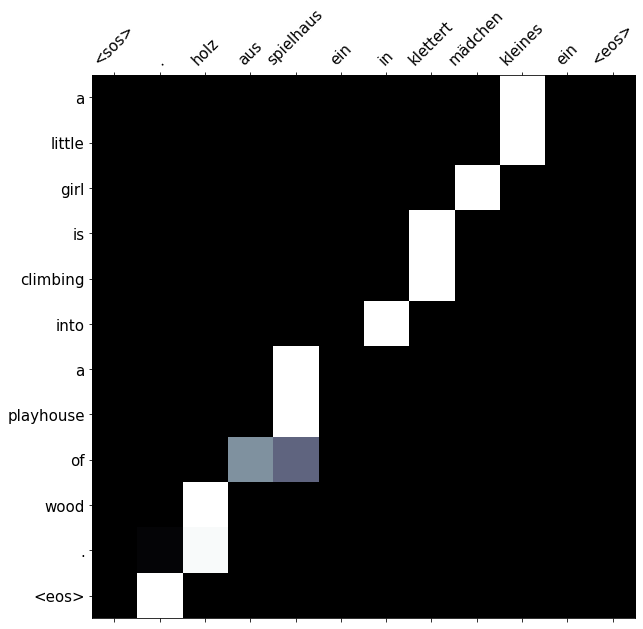

In [33]:
display_attention(src, translation, attention)

In [34]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'frau', 'einer', 'schultern', 'den', 'auf', 'sitzt', 'kopfhörern', 'mit', 'junge', 'ein']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


In [35]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'with', 'headphones', 'is', 'sitting', 'on', 'the', 'shoulders', 'of', 'a', 'woman', '.', '<eos>']


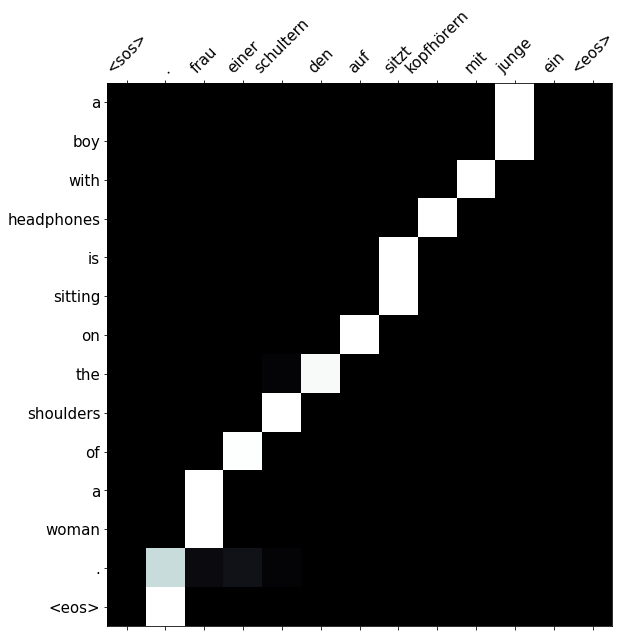

In [36]:
display_attention(src, translation, attention)

---
# 6. BLEU
---

In [37]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [38]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.27
